# Model Evaluation

It's nice to see the performance of the model on test and dev sets.
Two primary indicators of final performance are:
-   F1 Scores
    - Local
    - Global
-   Confusion Matrix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sn
import json
import rules

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score


from flair.data import Sentence
from flair.models import SequenceTagger
%matplotlib inline 

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [2]:
# Helper function for getting the predictions
def get_predictions(text, rules_engine, model):
    '''
    In case of multiple entities, this function return the entity with
    greatest confidence
    '''
    text = rules_engine.pin_text(text)
    sentence = Sentence(text)
    model.predict(sentence)
    result = sentence.to_dict(tag_type="ner")
    entities = [
        {
            "tagged_sentence": result.get('text'),
            "label": e.get('labels')[0].value,
            "entity": e.get('text'),
            "confidence": e.get('labels')[0].score
        }
        for e in result.get('entities')
    ]
    
    entities = sorted(entities, key=lambda c: c['confidence'])

    if entities:
        return entities[-1]
    else:
        return {"label": "None", "entity": "", "confidence": 0.0 , "tagged_sentence":result.get('text')}

In [3]:
# load the trained model
model = SequenceTagger.load('../model/taggers/pii-ner-v1/final-model.pt')

# load the rules engine
engine = rules.RulesEngine()

2021-02-01 14:50:11,037 loading file ../model/taggers/pii-ner-v1/final-model.pt


In [4]:
get_predictions(
    "Accept ready address firm continue phone camera. Discussion party party one. Worker voice foreign general everything yeah travel. Experience +1-821-995-3406x094 through somebody benefit.",
    engine, model
)

{'tagged_sentence': 'Accept ready address firm continue phone camera. Discussion party party one. Worker voice foreign general everything yeah travel. Experience ppppp +1-821-995-3406x094 hhhhh through somebody benefit.',
 'label': 'Phone_number',
 'entity': '1-821-995-3406x094',
 'confidence': 0.9986434578895569}

In [5]:
df = pd.read_excel("../data/augmented_data_dev.xlsx")
df.head()

,Unnamed: 0,Text,Labels,PII
0,1202,View consumer our. christinelewis@hill-rowe.co...,Email,christinelewis@hill-rowe.com
1,25,Such today election away. Month color officer ...,Email,kennethallen@turner.com
2,696,Positive cause I arrive 589-483-3388x4331 nigh...,Phone_number,589-483-3388x4331
3,1315,Support do total threat exist material. Here C...,Name,Craig
4,369,During technology weight appear gun. Soon clai...,Plates,971WL


In [6]:

y_true = df['Labels']
y_true_entities = df['PII']

predictions = df['Text'].map(
    lambda text: get_predictions(text, rules_engine=engine, model=model)
)

y_pred = [p.get('label') for p in predictions]
y_pred_entities = [p.get('entity') for p in predictions]

labels = list(set(y_pred))
labels.sort()
print("Total labels: %s -> %s" % (len(labels), labels))

Total labels: 8 -> ['Address', 'CreditCardNumber', 'Email', 'Name', 'None', 'Phone_number', 'Plates', 'SSN']


In [7]:
predictions[0]

{'tagged_sentence': 'View consumer our. eeeee christinelewis@hill-rowe.com mmmmm Kind simple support. Operation Democrat off red economic environment human.',
 'label': 'Email',
 'entity': 'christinelewis@hill-rowe.com',
 'confidence': 0.9992568492889404}

In [8]:
confusion_df = pd.DataFrame(
    data=confusion_matrix(y_true, y_pred, labels=labels),
    columns=labels,
    index=labels
)
confusion_df

,Address,CreditCardNumber,Email,Name,None,Phone_number,Plates,SSN
Address,100,0,0,0,0,0,0,0
CreditCardNumber,0,20,0,0,0,0,0,0
Email,0,0,20,0,0,0,0,0
Name,0,0,0,100,0,0,0,0
None,0,0,0,0,20,0,0,0
Phone_number,4,0,0,0,0,16,0,0
Plates,1,0,0,0,0,0,19,0
SSN,0,0,0,0,0,0,0,20


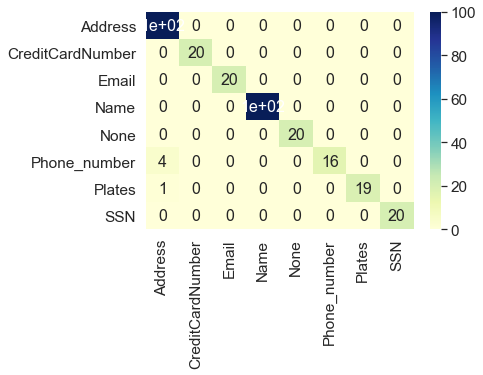

In [9]:
# show plot
sn.set(font_scale=1.4) # for label size
sn.heatmap(confusion_df, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size

plt.show()

In [10]:
report = []
#
# Local (metrics per class)
#
tps = {}
fps = {}
fns = {}
precision_local = {}
recall_local = {}
f1_local = {}
accuracy_local = {}
for label in labels:
    tps[label] = confusion_df.loc[label, label]
    fps[label] = confusion_df[label].sum() - tps[label]
    fns[label] = confusion_df.loc[label].sum() - tps[label]
    tp, fp, fn = tps[label], fps[label], fns[label]
    
    precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
    recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
    p, r = precision_local[label], recall_local[label]
    
    f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
    accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.

report.append("#-- Local measures --#" + "\n")
report.append("True Positives: \n" + json.dumps(tps,indent=2, cls=NpEncoder) + "\n")
report.append("False Positives: \n" + json.dumps(fps,indent=2, cls=NpEncoder) + "\n")
report.append("False Negatives: \n" + json.dumps(fns,indent=2, cls=NpEncoder) + "\n")
report.append("Precision: \n" + json.dumps(precision_local,indent=2, cls=NpEncoder) + "\n")
report.append("Recall: \n" + json.dumps(recall_local,indent=2, cls=NpEncoder) + "\n")
report.append("F1-Score: \n" + json.dumps(f1_local,indent=2, cls=NpEncoder) + "\n")
report.append("Accuracy: \n" + json.dumps(accuracy_local,indent=2, cls=NpEncoder) + "\n")


# [print(r) for r in report]

In [11]:
#
# Global
#
micro_averages = {}
macro_averages = {}

correct_predictions = sum(tps.values())
den = sum(list(tps.values()) + list(fps.values()))
micro_averages["Precision"] = 1. * correct_predictions / den if den > 0. else 0.

den = sum(list(tps.values()) + list(fns.values()))
micro_averages["Recall"] = 1. * correct_predictions / den if den > 0. else 0.

micro_avg_p, micro_avg_r = micro_averages["Precision"], micro_averages["Recall"]
micro_averages["F1-score"] = 2. * micro_avg_p * micro_avg_r / (micro_avg_p + micro_avg_r) if (micro_avg_p + micro_avg_r) > 0. else 0.

macro_averages["Precision"] = np.mean(list(precision_local.values()))
macro_averages["Recall"] = np.mean(list(recall_local.values()))

macro_avg_p, macro_avg_r = macro_averages["Precision"], macro_averages["Recall"]
macro_averages["F1-Score"] = 2. * macro_avg_p * macro_avg_r / (macro_avg_p + macro_avg_r) if (macro_avg_p + macro_avg_r) > 0. else 0.

total_predictions = confusion_df.values.sum()
accuracy_global = correct_predictions / total_predictions if total_predictions > 0. else 0.

report.append("#-- Global measures --#")
report.append("Micro-Averages:\n" +  json.dumps(micro_averages, indent=2, cls=NpEncoder) + "\n")
report.append("Macro-Averages:\n " + json.dumps(macro_averages, indent=2, cls=NpEncoder) + "\n")
report.append("Correct predictions: " + str(correct_predictions) + "\n")
report.append("Total predictions:" + str(total_predictions) + "\n")
report.append("Accuracy:" + str(accuracy_global) + "\n")

# [print(r) for r in report[:-6]]

In [12]:
#
# TN
#
tns = {}
for label in set(y_true):
    tns[label] = len(y_true) - (tps[label] + fps[label] + fns[label])

report.append("True Negatives:\n"+ json.dumps(tns, indent=2, cls=NpEncoder) + "\n")

In [13]:
accuracy_local_new = {}
for label in labels:
    tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
    accuracy_local_new[label] = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0. else 0.

total_true = sum(list(tps.values()) + list(tns.values()))
total_predictions = sum(list(tps.values()) + list(tns.values()) + list(fps.values()) + list(fns.values()))
accuracy_global_new = 1. * total_true / total_predictions if total_predictions > 0. else 0.

report.append("Accuracy (per class), with TNs:\n"+ json.dumps(accuracy_local_new, indent=2, cls=NpEncoder) + "\n")
report.append("Accuracy (per class), without TNs:\n"+ json.dumps(accuracy_local, indent=2, cls=NpEncoder) + "\n")
report.append("Accuracy (global), with TNs:\n"+ json.dumps(accuracy_global_new, indent=2, cls=NpEncoder) + "\n")
report.append("Accuracy (global), without TNs:\n"+ json.dumps(accuracy_global, indent=2, cls=NpEncoder) + "\n")

for r in report:
    print(r)

#-- Local measures --#

True Positives: 
{
  "Address": 100,
  "CreditCardNumber": 20,
  "Email": 20,
  "Name": 100,
  "None": 20,
  "Phone_number": 16,
  "Plates": 19,
  "SSN": 20
}

False Positives: 
{
  "Address": 5,
  "CreditCardNumber": 0,
  "Email": 0,
  "Name": 0,
  "None": 0,
  "Phone_number": 0,
  "Plates": 0,
  "SSN": 0
}

False Negatives: 
{
  "Address": 0,
  "CreditCardNumber": 0,
  "Email": 0,
  "Name": 0,
  "None": 0,
  "Phone_number": 4,
  "Plates": 1,
  "SSN": 0
}

Precision: 
{
  "Address": 0.9523809523809523,
  "CreditCardNumber": 1.0,
  "Email": 1.0,
  "Name": 1.0,
  "None": 1.0,
  "Phone_number": 1.0,
  "Plates": 1.0,
  "SSN": 1.0
}

Recall: 
{
  "Address": 1.0,
  "CreditCardNumber": 1.0,
  "Email": 1.0,
  "Name": 1.0,
  "None": 1.0,
  "Phone_number": 0.8,
  "Plates": 0.95,
  "SSN": 1.0
}

F1-Score: 
{
  "Address": 0.975609756097561,
  "CreditCardNumber": 1.0,
  "Email": 1.0,
  "Name": 1.0,
  "None": 1.0,
  "Phone_number": 0.888888888888889,
  "Plates": 0.9743589743

In [14]:
# save the report
with open('evaluation_report.txt', 'w', encoding="utf-8") as f:
    f.writelines(report)
